# wavelet-partition
tool to partition FLUXNET-CH4 data into diffusive and ebullitive fluxes

In [30]:
import pandas as pd
import numpy as np
import pywt
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from numpy.polynomial import Polynomial as P

set global matplotlib settings

In [31]:
plt.style.use('ggplot')
# text_kwargs = dict(ha='center', va='center', fontsize=28, color='C1') # global plotting settings

define multiresolution functions from pywt PR #527

In [32]:
from functools import partial, reduce
def mra(data, wavelet, level=None, axis=-1, transform='swt',
        mode='periodization'):
    """Forward 1D multiresolution analysis.
    It is a projection onto the wavelet subspaces.
    Parameters
    ----------
    data: array_like
        Input data
    wavelet : Wavelet object or name string
        Wavelet to use
    level : int, optional
        Decomposition level (must be >= 0). If level is None (default) then it
        will be calculated using the `dwt_max_level` function.
    axis: int, optional
        Axis over which to compute the DWT. If not given, the last axis is
        used. Currently only available when ``transform='dwt'``.
    transform : {'dwt', 'swt'}
        Whether to use the DWT or SWT for the transforms.
    mode : str, optional
        Signal extension mode, see `Modes` (default: 'symmetric'). This option
        is only used when transform='dwt'.
    Returns
    -------
    [cAn, {details_level_n}, ... {details_level_1}] : list
        For more information, see the detailed description in `wavedec`
    See Also
    --------
    ``imra``, ``swt``
    Notes
    -----
    This is sometimes referred to as an additive decomposition because the
    inverse transform (``imra``) is just the sum of the coefficient arrays
    [1]_. The decomposition using ``transform='dwt'`` corresponds to section
    2.2 while that using an undecimated transform (``transform='swt'``) is
    described in section 3.2 and appendix A.
    This transform does not share the variance partition property of ``swt``
    with `norm=True`. It does however, result in coefficients that are
    temporally aligned regardless of the symmetry of the wavelet used.
    The redundancy of this transform is ``(level + 1)``.
    References
    ----------
    .. [1] Donald B. Percival and Harold O. Mofjeld. Analysis of Subtidal
        Coastal Sea Level Fluctuations Using Wavelets. Journal of the American
        Statistical Association Vol. 92, No. 439 (Sep., 1997), pp. 868-880.
        https://doi.org/10.2307/2965551
    """
    if transform == 'swt':
        if mode != 'periodization':
            raise ValueError(
                "transform swt only supports mode='periodization'")
        kwargs = dict(wavelet=wavelet, norm=True)
        forward = partial(pywt.swt, level=level, trim_approx=True, **kwargs)
        if axis % data.ndim != data.ndim - 1:
            raise ValueError("swt only supports axis=-1")
        inverse = partial(pywt.iswt, **kwargs)
        is_swt = True
    elif transform == 'dwt':
        kwargs = dict(wavelet=wavelet, mode=mode, axis=axis)
        forward = partial(pywt.wavedec, level=level, **kwargs)
        inverse = partial(pywt.waverec, **kwargs)
        is_swt = False
    else:
        raise ValueError("unrecognized transform: {}".format(transform))

    wav_coeffs = forward(data)

    mra_coeffs = []
    nc = len(wav_coeffs)

    if is_swt:
        # replicate same zeros array to save memory
        z = np.zeros_like(wav_coeffs[0])
        tmp = [z, ] * nc
    else:
        # zero arrays have variable size in DWT case
        tmp = [np.zeros_like(c) for c in wav_coeffs]

    for j in range(nc):
        # tmp has arrays of zeros except for the jth entry
        tmp[j] = wav_coeffs[j]

        # reconstruct
        rec = inverse(tmp)
        if rec.shape != data.shape:
            # trim any excess coefficients
            rec = rec[tuple([slice(sz) for sz in data.shape])]
        mra_coeffs.append(rec)

        # restore zeros
        if is_swt:
            tmp[j] = z
        else:
            tmp[j] = np.zeros_like(tmp[j])
    return mra_coeffs


def imra(mra_coeffs):
    """Inverse 1D multiresolution analysis via summation.
    Parameters
    ----------
    mra_coeffs : list of ndarray
        Multiresolution analysis coefficients as returned by `mra`.
    Returns
    -------
    rec : ndarray
        The reconstructed signal.
    See Also
    --------
    ``mra``
    References
    ----------
    .. [1] Donald B. Percival and Harold O. Mofjeld. Analysis of Subtidal
        Coastal Sea Level Fluctuations Using Wavelets. Journal of the American
        Statistical Association Vol. 92, No. 439 (Sep., 1997), pp. 868-880.
        https://doi.org/10.2307/2965551
    """
    return reduce(lambda x, y: x + y, mra_coeffs)

## Import data and process

FLUXNET-CH4 data stored on google drive, split google drive url and import with pandas

In [33]:
def pd_read_from_drive(site_id='FLX_JP-Swl'):
    '''reads csv from google drive url into pandas dataframe'''
    if site_id == 'FLX_JP-Swl': # urls could be stored as a dict {site_id : url}
        url = "https://drive.google.com/file/d/1Pudof9T3_TOxpd5eY2F9ZjyvGxFub4Rg/view?usp=sharing"
    elif site_id == 'FLX_JP-BBY':
        url = "https://drive.google.com/file/d/1bMn9xCFZJ8Z1xVZmJ-Z8Xu0AH8xskyYs/view?usp=sharing"
    else: 
        raise ValueError("not a valid site_id!") # could be KeyError with dict
    file_id=url.split('/')[-2]
    dwn_url='https://drive.google.com/uc?id=' + file_id
    return pd.read_csv(dwn_url)

## JP-Swl

read, replace missing, parse timestamp

In [34]:
df = pd_read_from_drive('FLX_JP-Swl') # read
df = df.replace(-9999, np.nan) # replace missing with nan
df["date"] = pd.to_datetime(df["TIMESTAMP_START"], format='%Y%m%d%H%M') # parse timestamp to new column 'date'

### Find portion to partition

select all rows from selected columns

In [35]:
df = df.loc[:, ['date', "LE", "FCH4", "TA", "FCH4_F", "TA_F"]]

plot entire FCH4 series vs time

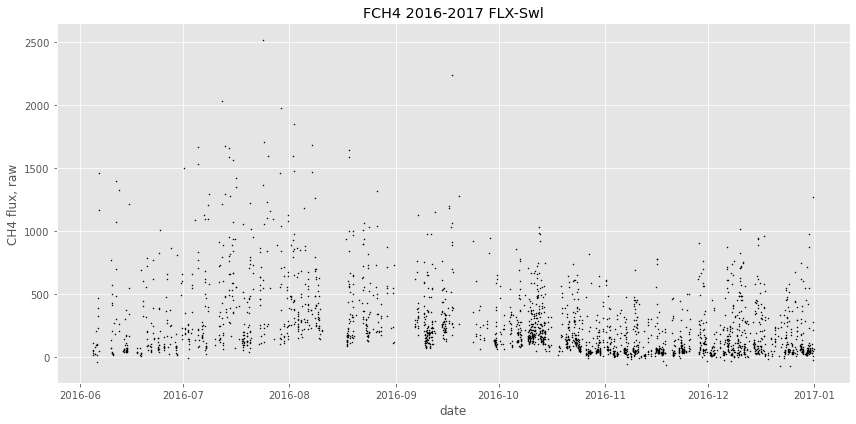

In [36]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(df['date'], df['FCH4'], c='k', s=1)
ax.set_ylabel("CH4 flux, raw")
ax.set_xlabel("date")
ax.set_title("FCH4 2016-2017 FLX-Swl")
plt.tight_layout()

limit date range, into new Dataframe data

(roughly 2016-06-01 to 2016-08-15 looks relatively continuous)

In [37]:
dfw = df[((df['date'] >= '2016-01-01') & (df['date'] <= '2016-08-11'))]

plot FCH4 and FCH4_F

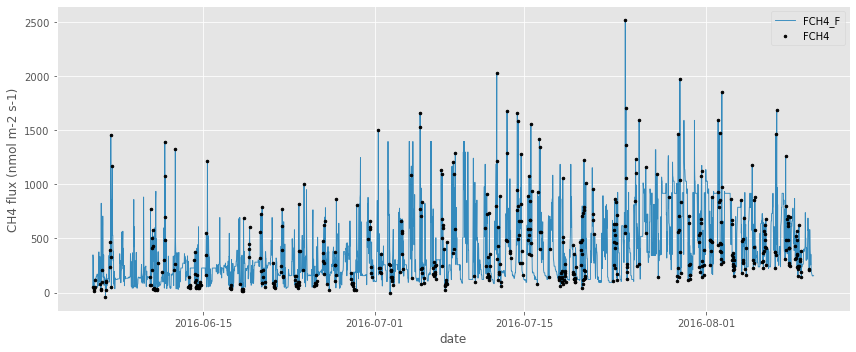

In [38]:
fig, ax = plt.subplots(figsize=(12,5))

ax.plot(dfw['date'], dfw['FCH4_F'], list(plt.rcParams['axes.prop_cycle'])[1]['color'], 
        dfw['date'], dfw['FCH4'], 'k.', markersize=5, linewidth=0.9)
ax.set_xlabel('date')
ax.set_ylabel('CH4 flux (nmol m-2 s-1)')
ax.legend(['FCH4_F', 'FCH4']) # not sure why this order, this is workaround
plt.tight_layout()

gap-filling is adding some serious fluctuations in gaps of seemingly days? I want to trim that big gap ~06-06 to 06-09

better way to zoom would be to find first non-nan value in FCH4 vector and corresponding date

edit: Series.first_valid_index() returns index of first non-nan (.last_... returns last)

In [39]:
# dfw = df[df['FCH4'][df['date'] >= '2016-06-08'].first_valid_index():df['FCH4'][df['date'] <= '2016-08-15'].last_valid_index()]
# dfw

### Gap-filled sanity check

chop between first and last nans from 06-10 and 08-10

In [40]:
mask = (df['date'] >= '2016-06-10') & (df['date'] <= '2016-08-10')
first_valid_loc = df.loc[mask, 'FCH4'].first_valid_index()
last_valid_loc = df.loc[mask, 'FCH4'].last_valid_index()

dfw = df.loc[first_valid_loc:last_valid_loc]

verify that we chopped that first big gap

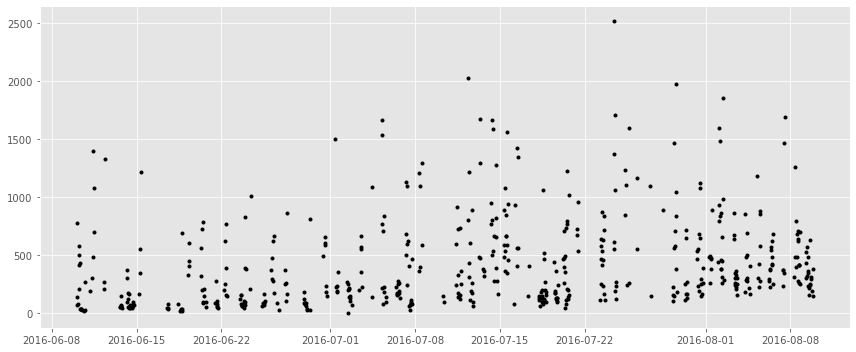

In [41]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(dfw['date'], dfw['FCH4'], 'k.')
plt.tight_layout()

normalize gap-filled data by mean over summer
- FCH4_F not normal dist with overall dfw mean
- much more normal with rolling mean, window size 96 (two days)
- TA more normal with overall dfw mean

In [42]:
# manually pad two nans on 06-20 (throws off Polynomial.fit)
df.loc[first_valid_loc:last_valid_loc, 'TA_F'].fillna(method='pad', limit=2, inplace=True)

# check if any nans left
dfw['TA_F'].isna().any()

False

In [43]:
# normalize by rolling mean, window = 48 hrs
df.loc[first_valid_loc:last_valid_loc,'FCH4_Froll'] = dfw['FCH4_F'] - dfw['FCH4_F'].rolling(96).mean()
df.loc[first_valid_loc:last_valid_loc, 'TA_Froll'] = dfw['TA_F'] - dfw['TA_F'].rolling(96).mean()

In [44]:
# fit polynomials
pM = P.fit(range(len(dfw['FCH4_F'])), dfw['FCH4_F'], 2)
pT = P.fit(range(len(dfw['TA_F'])), dfw['TA_F'], 2)

#get (x, y) points from fit polynomials 
xpM, ypM = pM.linspace(len(dfw['FCH4_F']))
xpT, ypT = pT.linspace(len(dfw['TA_F']))

In [45]:
df.loc[first_valid_loc:last_valid_loc, 'FCH4_Fn'] = dfw.loc[:, 'FCH4_F'] - ypM
df.loc[first_valid_loc:last_valid_loc, 'TA_Fn'] = dfw.loc[:, 'TA_F'] - ypT

dfw = df.loc[first_valid_loc:last_valid_loc]

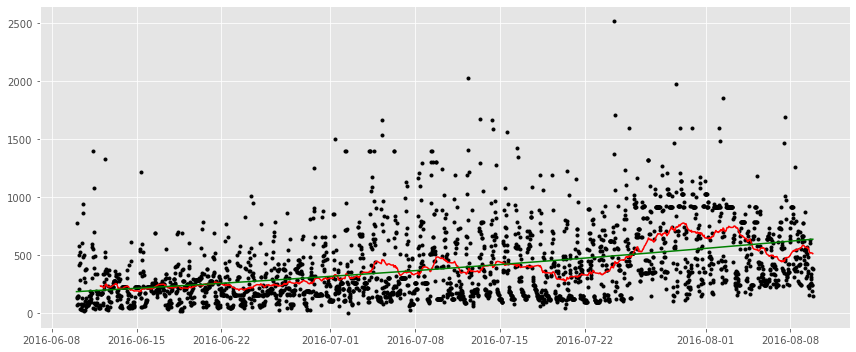

In [46]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(dfw['date'], dfw['FCH4_F'], 'k.',
        dfw['date'], dfw['FCH4_F'].rolling(96).mean(), 'r-',
        dfw['date'], ypM, 'g-')

plt.tight_layout()

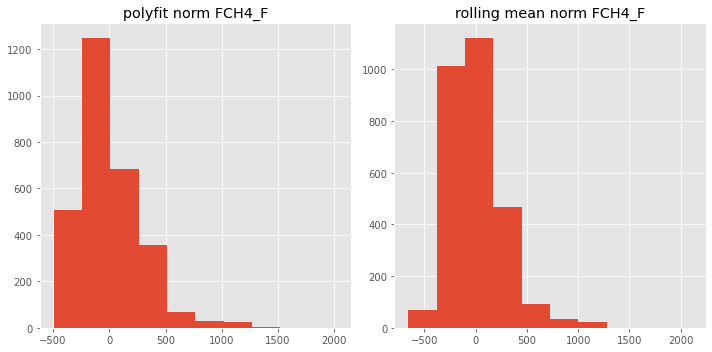

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].hist(df.loc[first_valid_loc:last_valid_loc, 'FCH4_Fn'])
ax[0].set_title('polyfit norm FCH4_F')
ax[1].hist(df.loc[first_valid_loc:last_valid_loc, 'FCH4_Froll'])
ax[1].set_title('rolling mean norm FCH4_F')
plt.tight_layout()

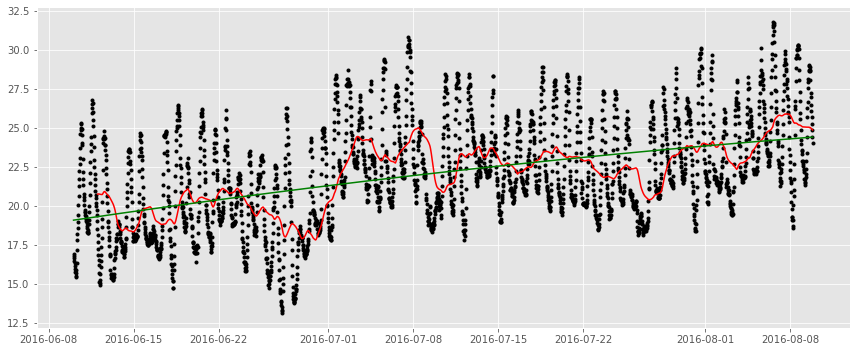

In [48]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(dfw['date'], dfw['TA_F'], 'k.',
        dfw['date'], dfw['TA_F'].rolling(96).mean(), 'r-',
        dfw['date'], ypT, 'g-')

plt.tight_layout()

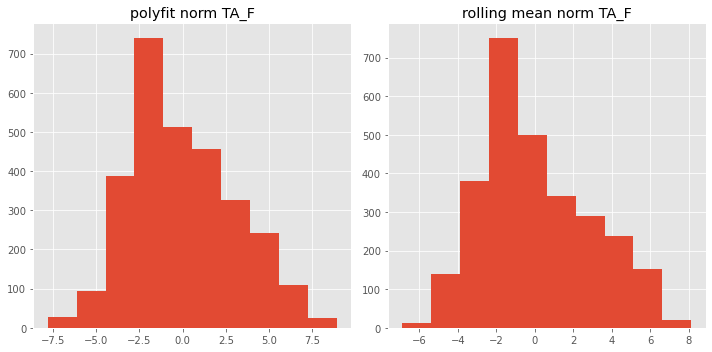

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].hist(df.loc[first_valid_loc:last_valid_loc, 'TA_Fn'])
ax[0].set_title('polyfit norm TA_F')
ax[1].hist(df.loc[first_valid_loc:last_valid_loc, 'TA_Froll'])
ax[1].set_title('rolling mean norm TA_F')
plt.tight_layout()

compute DWT at maximum useful levels (pywt computes max freq resolution)

In [50]:
cM = pywt.wavedec(dfw['FCH4_Fn'], 'haar')
cT = pywt.wavedec(dfw['TA_Fn'], 'haar')

In [51]:
# full multi-level reconstruction
df.loc[first_valid_loc:last_valid_loc, 'FCH4_rec'] = pywt.waverec(cM, 'haar')
dfw = df.loc[first_valid_loc:last_valid_loc]

In [52]:
# compute wavelet coefficients using additive decomposition
c = mra(dfw['FCH4_Fn'], 'sym8', transform='dwt')

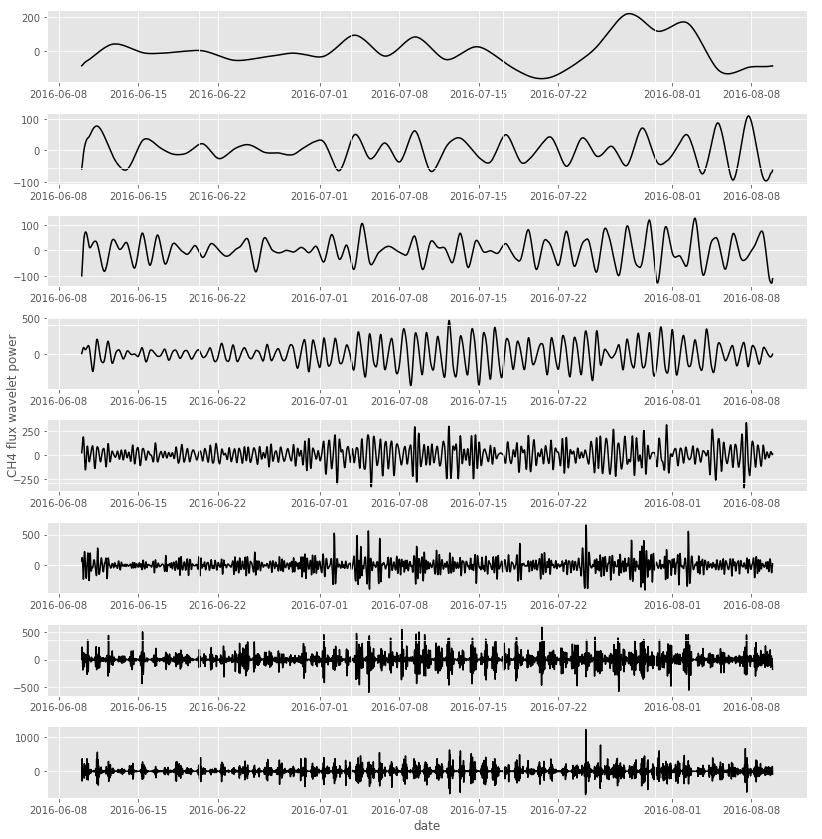

In [53]:
fig, ax = plt.subplots(len(c), 1, figsize=(12,12))

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.ylabel("CH4 flux wavelet power")

for i in range(len(c)):
    ax[i].plot(dfw['date'], c[i], 'k-')

ax[len(c)-1].set(xlabel='date')
plt.tight_layout()

In [54]:
# sum adjacent scales
csum = [c[i] + c[i+1] for i in range(0, len(c), 2)]
scales = [int(len(csum[i-1])/(i*4)) for i in range(1, len(csum))]

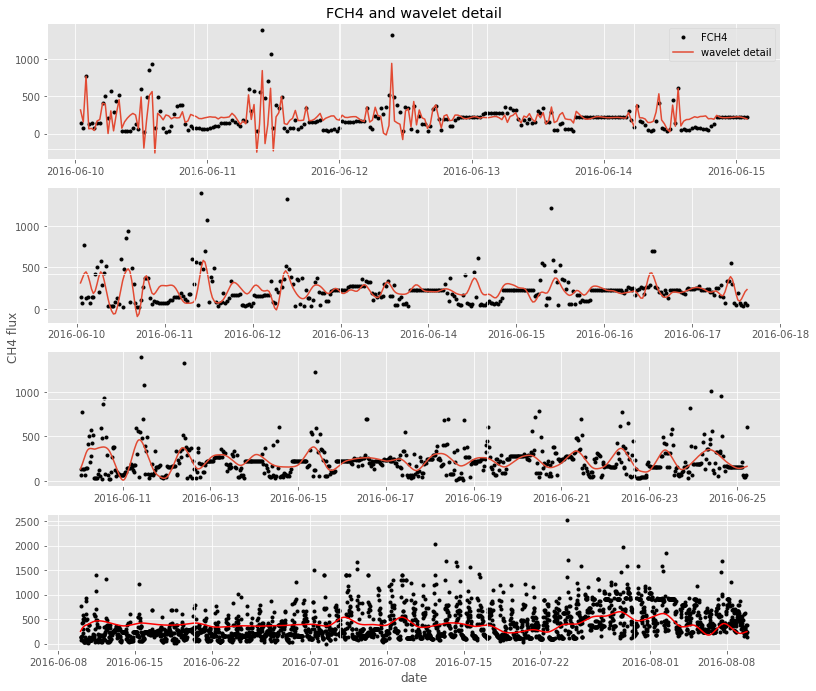

In [55]:
fig, ax = plt.subplots(4, 1, figsize=(12,10))

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.ylabel("CH4 flux")

ax[0].plot(dfw['date'][:scales[2]], dfw['FCH4_F'][:scales[2]], 'k.',
          dfw['date'][:scales[2]], csum[3][:scales[2]] + dfw['FCH4_F'][:scales[2]].mean())

ax[1].plot(dfw['date'][:scales[1]], dfw['FCH4_F'][:scales[1]], 'k.',
          dfw['date'][:scales[1]], csum[2][:scales[1]] + dfw['FCH4_F'][:scales[1]].mean())

ax[2].plot(dfw['date'][:scales[0]], dfw['FCH4_F'][:scales[0]], 'k.',
          dfw['date'][:scales[0]], csum[1][:scales[0]] + dfw['FCH4_F'][:scales[0]].mean())

ax[-1].plot(dfw['date'], dfw['FCH4_F'], 'k.',
           dfw['date'], csum[0] + dfw['FCH4_F'].mean(), 'r-')
ax[0].set(title="FCH4 and wavelet detail")
ax[0].legend(['FCH4', 'wavelet detail'])
ax[-1].set(xlabel='date')
plt.tight_layout()

scatter of wavelet coefficients

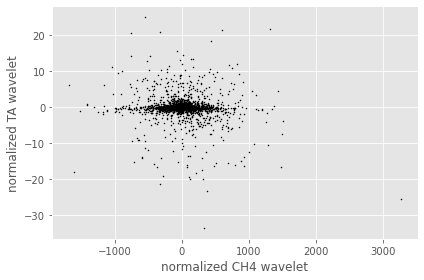

In [56]:
# need to cast as pd.Dataframe to transpose?
cM_pd = pd.DataFrame(cM).transpose()
cT_pd = pd.DataFrame(cT).transpose()

fig, ax = plt.subplots()

for i in range(cM_pd.shape[1]):
    ax.scatter(cM_pd[i], cT_pd[i], c='k', s=1)
plt.xlabel("normalized CH4 wavelet")
plt.ylabel("normalized TA wavelet")
plt.tight_layout()

limit plot window

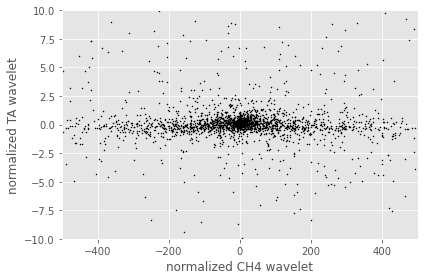

In [57]:
fig, ax = plt.subplots()

for i in range(cM_pd.shape[1]):
    ax.scatter(cM_pd[i], cT_pd[i], c='k', s=1)
plt.xlabel("normalized CH4 wavelet")
plt.ylabel("normalized TA wavelet")
plt.tight_layout()

plt.xlim(-500, 500)
plt.ylim(-10, 10)
plt.tight_layout()

# junk / test

compute wavelet transform on gap-filled NOT NORMALIZED data in dfw (df between 06-10 and 08-10)

In [11]:
cMF = pd.DataFrame(pywt.wavedec(df['FCH4_F'], 'haar')).transpose()
cTF = pd.DataFrame(pywt.wavedec(df['TA_F'], 'haar')).transpose()

scatter of wavelet coefficients

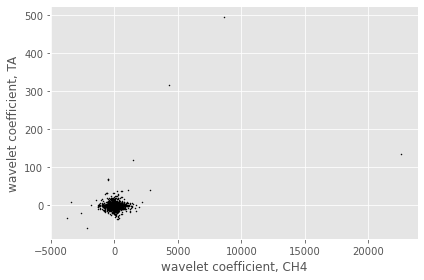

In [12]:
fig, ax = plt.subplots()

for i in range(cMF.shape[1]):
    ax.scatter(cMF[i], cTF[i], c='k', s=1)
plt.xlabel("wavelet coefficient, CH4")
plt.ylabel("wavelet coefficient, TA")
plt.tight_layout()

limit plot window

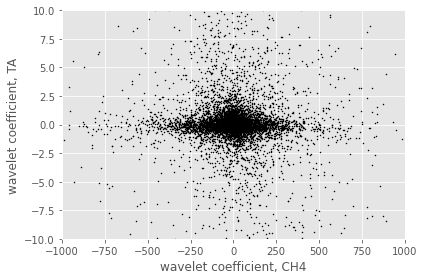

In [13]:
fig, ax = plt.subplots()

for i in range(cMF.shape[1]):
    ax.scatter(cMF[i], cTF[i], c='k', s=1)
plt.xlabel("wavelet coefficient, CH4")
plt.ylabel("wavelet coefficient, TA")
plt.xlim(-1000, 1000)
plt.ylim(-10, 10)
plt.tight_layout()

### Manual Padding

forward-pad nans to new column "FCH4_P", plot comparing padded series

In [23]:
# num_pad = 4 
# for i in range(num_pad):
#     df['FCH4_P{}'.format(i+1)] = df["FCH4"].fillna(method="pad", limit=i+1)
    
# fig, ax = plt.subplots(num_pad+1, 1, sharey=True, figsize=(12,15))

# for i in range(num_pad):
#     ax[i].plot(dfw['date'], dfw['FCH4_P{}'.format(i+1)], 'k.')
#     ax[i].set(ylabel='CH4 flux, (nmol m-2 s-1)', title='CH4 flux, pad limit = {}'.format(i+1))

# ax[num_pad].plot(dfw['date'], dfw['FCH4'], 'k.')
# ax[num_pad].set(xlabel='date', ylabel='CH4 flux (nmol m-2 s-1)', 
#                 title='CH4 flux, no pad')
# plt.tight_layout()

misguided? defunct? find continuous measurements, group_by cumsum of isna(), bigger groups are longer continuous chunks


In [25]:
# dfw['group_no'] = dfw['FCH4'].isna().cumsum()

# dfg = df.groupby('group_no').filter(lambda x: len(x) == 1)
# d = {i: df.loc[df.group_no == i, ['date', 'FCH4']] 
#      for i in range(1, df.group_no.iat[-1])}
# # ds = pd.DataFrame(d)

plot histogram of gap lengths for different pad limits

scatter FCH4_F and FCH4 vs time

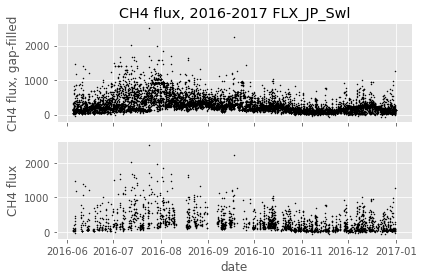

In [89]:
fig, ax = plt.subplots(2, 1, sharex=True, sharey=False)
ax[0].scatter(df['date'], df['FCH4_F'], c='k', s=1)
ax[0].set_ylabel("CH4 flux, gap-filled")
ax[0].set_title("CH4 flux, 2016-2017 FLX_JP_Swl")

ax[1].scatter(df['date'], df['FCH4'], c='k', s=1)
ax[1].set_ylabel("CH4 flux")
ax[1].set_xlabel("date")
plt.tight_layout()

compute wavelet transform on gap-filled data

In [6]:
cM = pd.DataFrame(pywt.wavedec(df['FCH4_F'], 'haar')).transpose()
cT = pd.DataFrame(pywt.wavedec(df['TA_F'], 'haar')).transpose()

scatter of wavelet coefficients

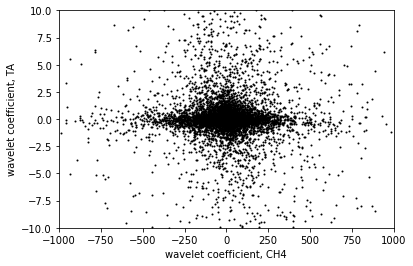

In [142]:
fig, ax = plt.subplots()

for i in range(cM.shape[1]):
    ax.scatter(cM[i], cT[i], c='k', s=1)
plt.xlabel("wavelet coefficient, CH4")
plt.ylabel("wavelet coefficient, TA")
plt.xlim(-1000, 1000)
plt.ylim(-10, 10)
plt.show()

scatter of FCH4 and TA vs time

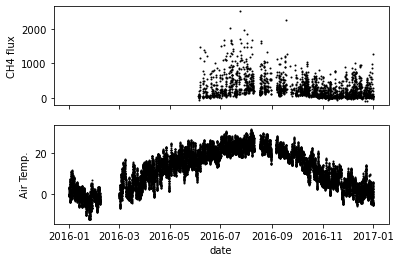

In [143]:
fig, axs = plt.subplots(2, 1, sharex=True, sharey=False)

axs[0].scatter(df['date'], df['FCH4'], c='k', s=1)
axs[0].set_ylabel('CH4 flux')

axs[1].scatter(df['date'], df['TA'], c='k', s=1)
axs[1].set_ylabel('Air Temp.')
axs[1].set_xlabel('date')
plt.show()